In [2]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
from dask.distributed import Client
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from sidm.tools import ffschema, sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(ffschema)
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
from tqdm.notebook import tqdm

In [3]:
samples_nano = [
    "TTJets",
    
    "4mu_500GeV_5p0GeV_0p08mm",
    "4mu_500GeV_5p0GeV_0p8mm",
    "4mu_500GeV_5p0GeV_8p0mm",
    "4mu_500GeV_5p0GeV_40p0mm",
    "4mu_500GeV_5p0GeV_80p0mm",
]

In [4]:
print(events_nano["4mu_500GeV_5p0GeV_0p08mm"].fields)

['ChsMET', 'GenJet', 'SoftActivityJetHT10', 'L1Reco', 'FatJet', 'DSAMuonVertex', 'PatMuonVertexRefittedTracks', 'Flag', 'HLTriggerFirstPath', 'Generator', 'HTXS', 'GenDressedLepton', 'SoftActivityJetHT2', 'LHEWeight', 'fixedGridRhoFastjetCentral', 'Photon', 'LHEReweightingWeight', 'LHEPdfWeight', 'LHEScaleWeight', 'SubGenJetAK8', 'L1PreFiringWeight', 'HLTriggerFinalPath', 'MET', 'SoftActivityJetNjets10', 'LHEPart', 'DSAMuonVertexRefittedTracks', 'Electron', 'GenPart', 'fixedGridRhoFastjetCentralCalo', 'SoftActivityJetHT5', 'event', 'GenJetAK8', 'Muon', 'Pileup', 'LHE', 'RawMET', 'CorrT1METJet', 'btagWeight', 'SoftActivityJet', 'BS', 'IsoTrack', 'FsrPhoton', 'GenIsolatedPhoton', 'SubJet', 'PatDSAMuonVertexRefittedTracks', 'PatMuonVertex', 'L1simulation', 'DeepMETResponseTune', 'GenVisTau', 'fixedGridRhoFastjetCentralNeutral', 'RawPuppiMET', 'SoftActivityJetHT', 'TrigObj', 'genTtbarId', 'HLT', 'DeepMETResolutionTune', 'PatDSAMuonVertex', 'Jet', 'SV', 'PuppiMET', 'SoftActivityJetNjets2', 

In [5]:
print(events_nano["4mu_500GeV_5p0GeV_0p08mm"].Jet.fields)

['area', 'btagCSVV2', 'btagDeepB', 'btagDeepCvB', 'btagDeepCvL', 'btagDeepFlavB', 'btagDeepFlavCvB', 'btagDeepFlavCvL', 'btagDeepFlavQG', 'chEmEF', 'chFPV0EF', 'chHEF', 'eta', 'hfsigmaEtaEta', 'hfsigmaPhiPhi', 'mass', 'muEF', 'muonSubtrFactor', 'neEmEF', 'neHEF', 'phi', 'pt', 'puIdDisc', 'qgl', 'rawFactor', 'bRegCorr', 'bRegRes', 'cRegCorr', 'cRegRes', 'electronIdx1', 'electronIdx2', 'hfadjacentEtaStripsSize', 'hfcentralEtaStripSize', 'jetId', 'muonIdx1', 'muonIdx2', 'nElectrons', 'nMuons', 'puId', 'nConstituents', 'genJetIdx', 'hadronFlavour', 'partonFlavour', 'cleanmask', 'electronIdx1G', 'electronIdx2G', 'genJetIdxG', 'muonIdx1G', 'muonIdx2G', 'muonIdxG', 'electronIdxG']


In [6]:
events_nano["4mu_500GeV_5p0GeV_0p08mm"].Jet.pt

<Array [[288, 266, 32, ... 155, 39.2, 15.4]] type='2004 * var * float32[paramete...'>

In [7]:
print(events_nano["4mu_500GeV_5p0GeV_0p08mm"].FatJet.fields)

['area', 'btagCSVV2', 'btagDDBvLV2', 'btagDDCvBV2', 'btagDDCvLV2', 'btagDeepB', 'btagHbb', 'deepTagMD_H4qvsQCD', 'deepTagMD_HbbvsQCD', 'deepTagMD_TvsQCD', 'deepTagMD_WvsQCD', 'deepTagMD_ZHbbvsQCD', 'deepTagMD_ZHccvsQCD', 'deepTagMD_ZbbvsQCD', 'deepTagMD_ZvsQCD', 'deepTagMD_bbvsLight', 'deepTagMD_ccvsLight', 'deepTag_H', 'deepTag_QCD', 'deepTag_QCDothers', 'deepTag_TvsQCD', 'deepTag_WvsQCD', 'deepTag_ZvsQCD', 'eta', 'mass', 'msoftdrop', 'n2b1', 'n3b1', 'particleNetMD_QCD', 'particleNetMD_Xbb', 'particleNetMD_Xcc', 'particleNetMD_Xqq', 'particleNet_H4qvsQCD', 'particleNet_HbbvsQCD', 'particleNet_HccvsQCD', 'particleNet_QCD', 'particleNet_TvsQCD', 'particleNet_WvsQCD', 'particleNet_ZvsQCD', 'particleNet_mass', 'phi', 'pt', 'rawFactor', 'tau1', 'tau2', 'tau3', 'tau4', 'lsf3', 'jetId', 'subJetIdx1', 'subJetIdx2', 'electronIdx3SJ', 'muonIdx3SJ', 'nConstituents', 'genJetAK8Idx', 'hadronFlavour', 'nBHadrons', 'nCHadrons', 'genJetAK8IdxG', 'subJetIdx1G', 'subJetIdx2G', 'subJetIdxG']


In [4]:
fileset = utilities.make_fileset(samples_nano, "llpNanoAOD_v2", max_files=1)

runner = processor.Runner(
    executor=processor.IterativeExecutor(),
    #executor=processor.FuturesExecutor(),
    schema=NanoAODSchema,
    #maxchunks=1,
)

channels = ["base", "2mu2e", "4mu"]
p = sidm_processor.SidmProcessor(
    channels,
    ["base"],
    lj_reco_choices=["0.4"],
    llpnanoaod=True,
)

output = runner.run(fileset, treename="Events", processor_instance=p)
out = output["out"]

Output()

Output()

/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered 
in divide
  result = getattr(ufunc, method)(

/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in
divide
  result = getattr(ufunc, method)(

#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


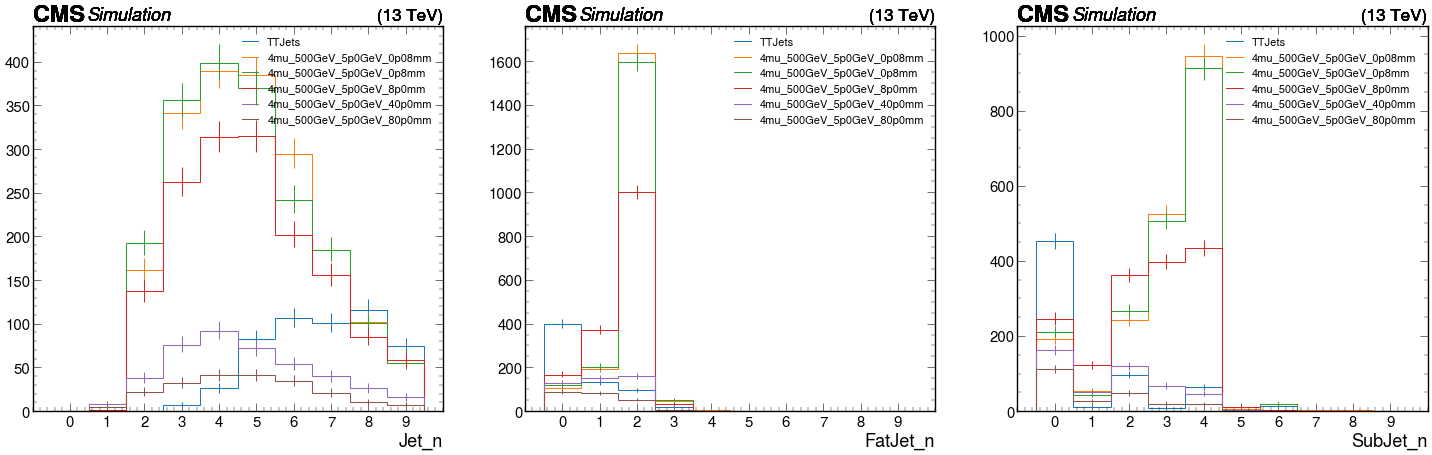

In [4]:
plt.subplots(1,3,figsize=(36,10))

plt.subplot(1,3,1)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["jet_n"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

plt.subplot(1,3,2)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["fatjet_n"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

plt.subplot(1,3,3)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["subjet_n"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

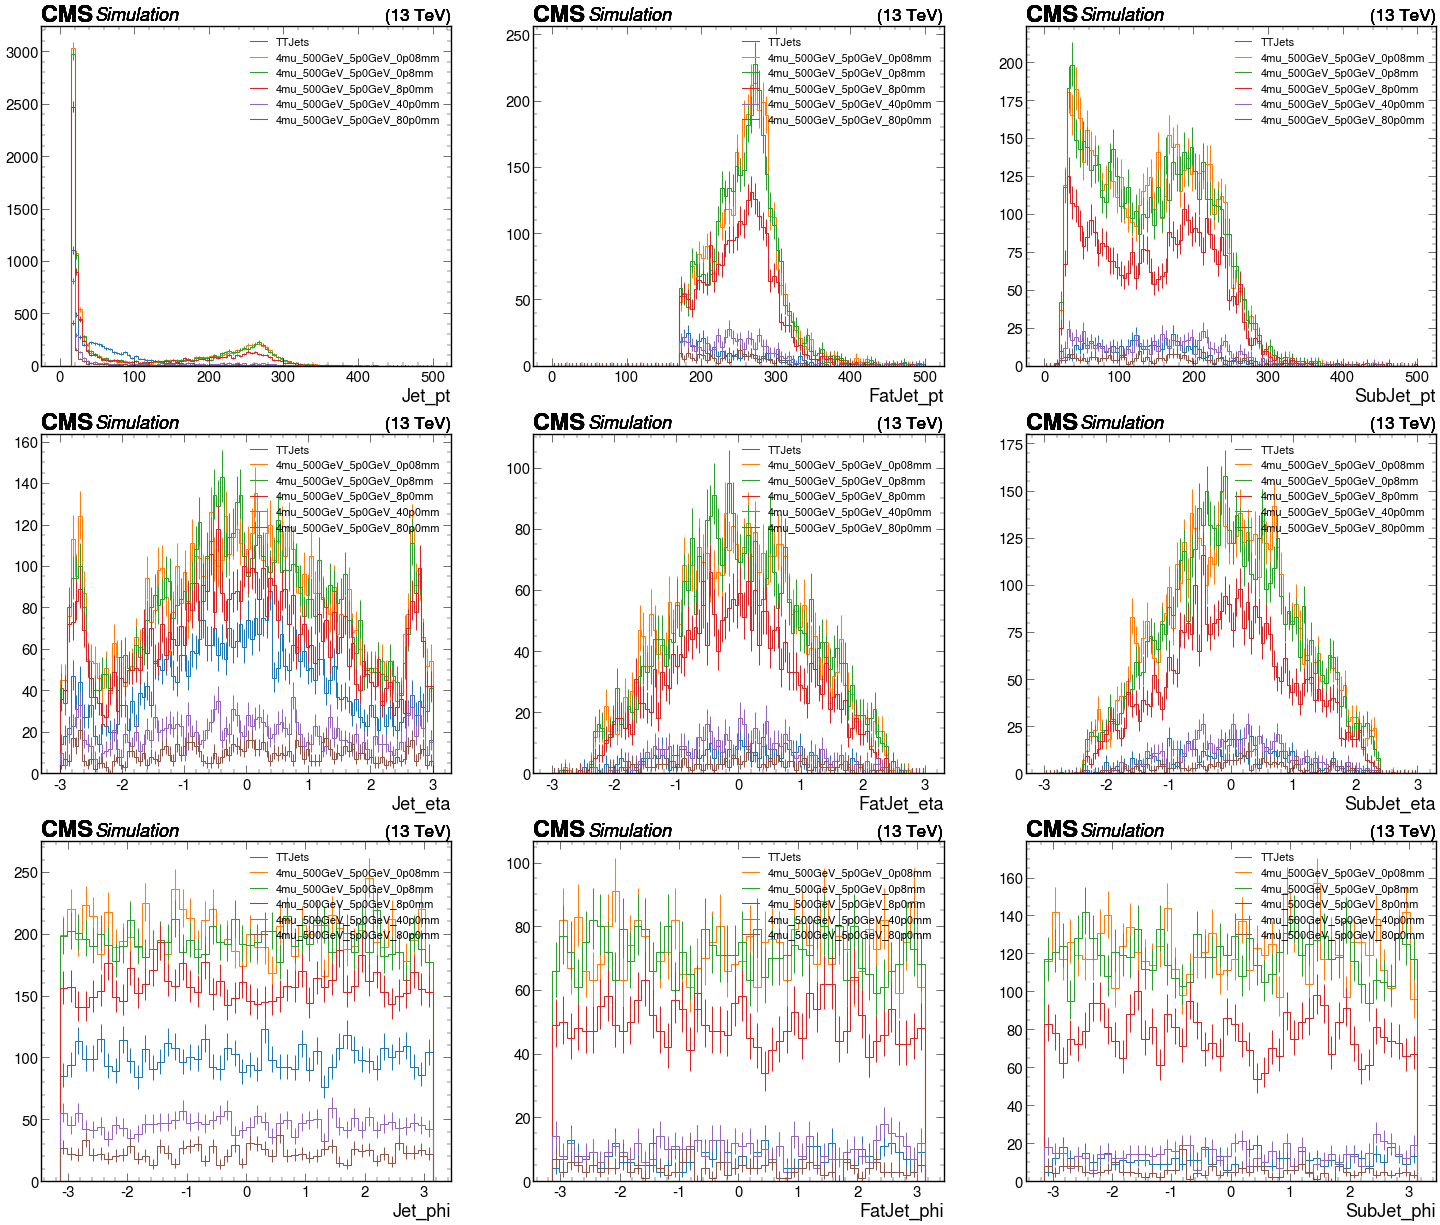

In [5]:
plt.subplots(3,3,figsize=(36,30))

plt.subplot(3,3,1)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["jet_pt"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

plt.subplot(3,3,2)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["fatjet_pt"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

plt.subplot(3,3,3)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["subjet_pt"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

plt.subplot(3,3,4)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["jet_eta"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

plt.subplot(3,3,5)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["fatjet_eta"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

plt.subplot(3,3,6)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["subjet_eta"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

plt.subplot(3,3,7)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["jet_phi"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

plt.subplot(3,3,8)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["fatjet_phi"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

plt.subplot(3,3,9)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["subjet_phi"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})

(0.0, 1800.0)

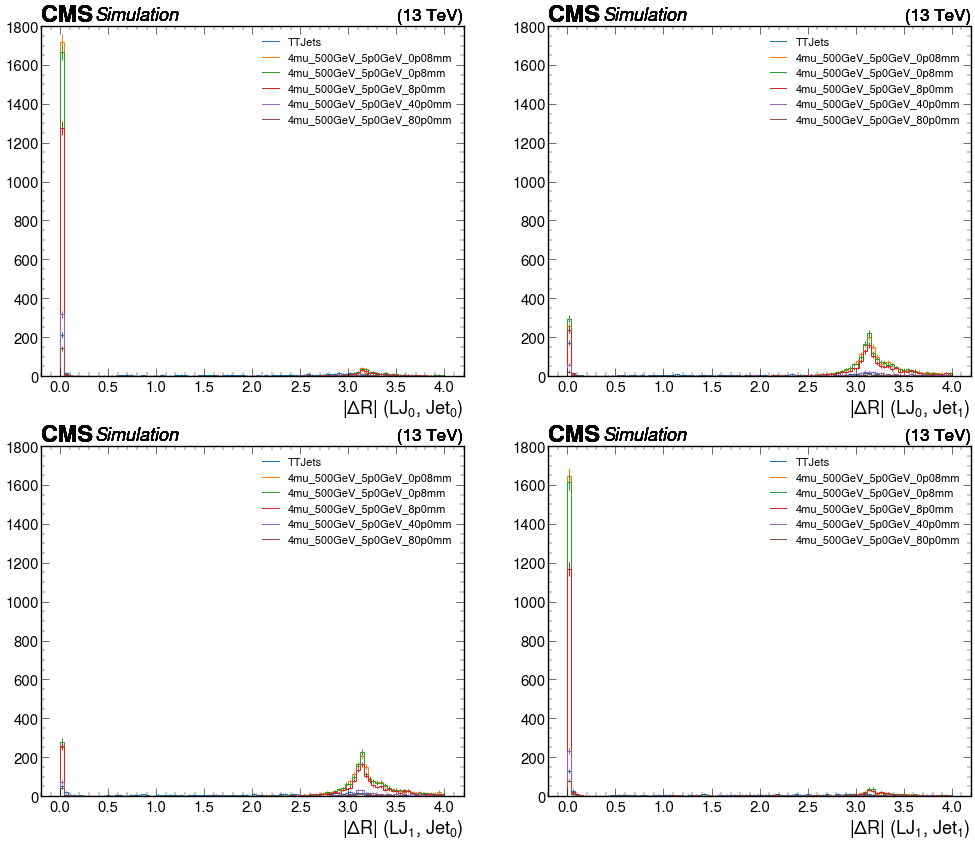

In [4]:
plt.subplots(2,2,figsize=(24,20))

plt.subplot(2,2,1)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj1_jet1_absdR"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.ylim(0,1800)

plt.subplot(2,2,2)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj1_jet2_absdR"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.ylim(0,1800)

plt.subplot(2,2,3)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj2_jet1_absdR"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.ylim(0,1800)

plt.subplot(2,2,4)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj2_jet2_absdR"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.ylim(0,1800)

(0.0, 2100.0)

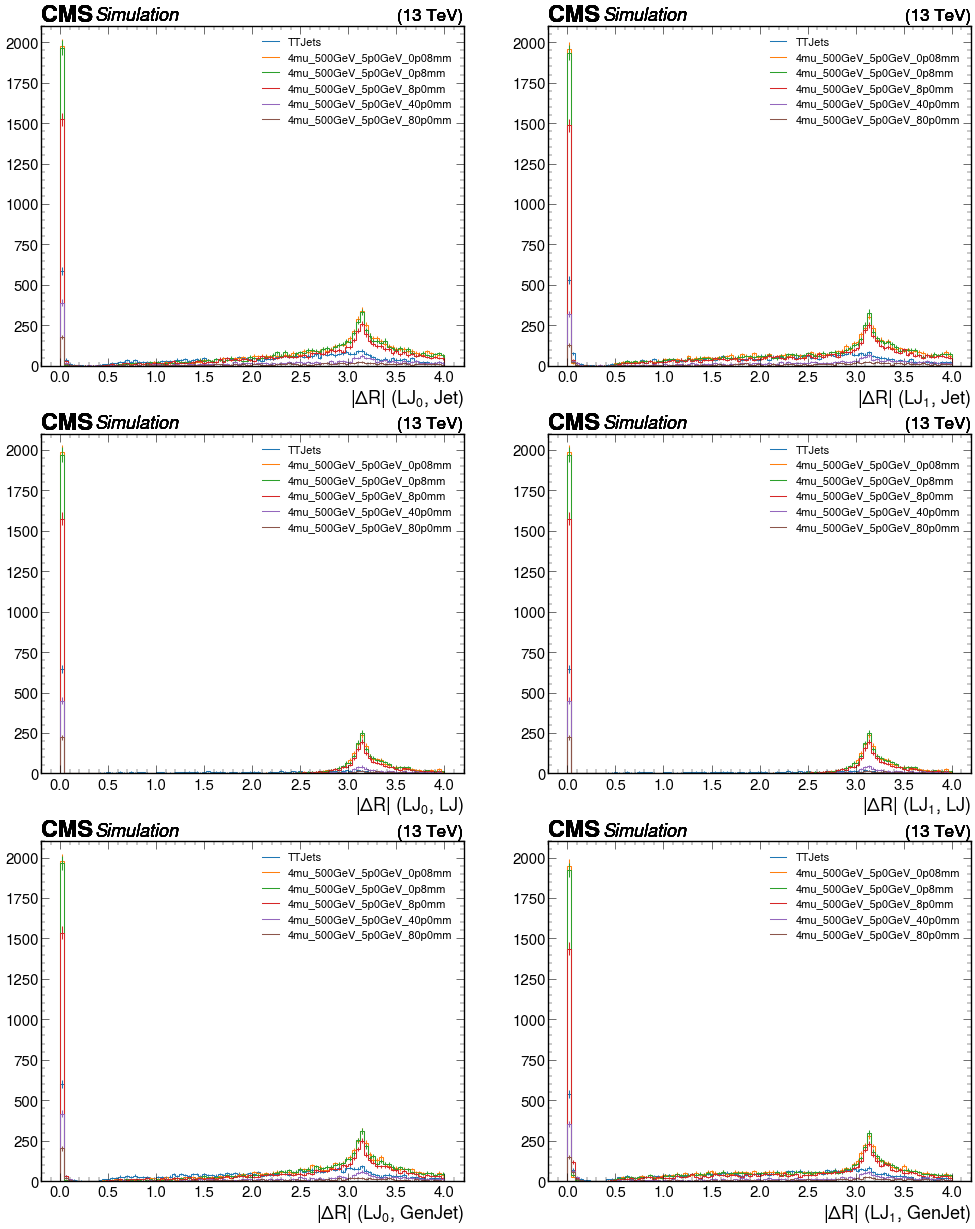

In [5]:
plt.subplots(3,2,figsize=(24,30))

plt.subplot(3,2,1)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj1_jet_absdR"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.ylim(0,2100)

plt.subplot(3,2,2)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj2_jet_absdR"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.ylim(0,2100)

plt.subplot(3,2,3)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj1_lj_absdR"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.ylim(0,2100)

plt.subplot(3,2,4)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj2_lj_absdR"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.ylim(0,2100)

plt.subplot(3,2,5)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj1_genjet_absdR"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.ylim(0,2100)

plt.subplot(3,2,6)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj2_genjet_absdR"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.ylim(0,2100)

(0.0, 200.0)

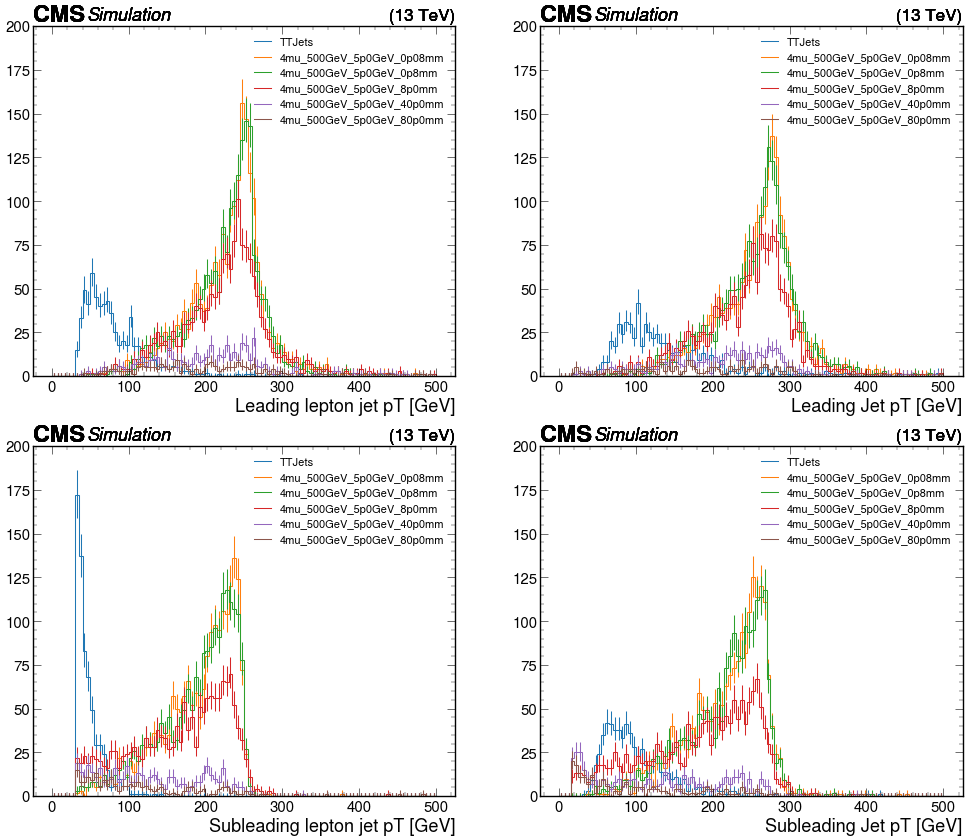

In [6]:
plt.subplots(2,2,figsize=(24,20))

plt.subplot(2,2,1)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj0_pt"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.ylim(0,200)

plt.subplot(2,2,2)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["jet1_pt"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.ylim(0,200)

plt.subplot(2,2,3)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj1_pt"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.ylim(0,200)

plt.subplot(2,2,4)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["jet2_pt"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.ylim(0,200)

(0.0, 300.0)

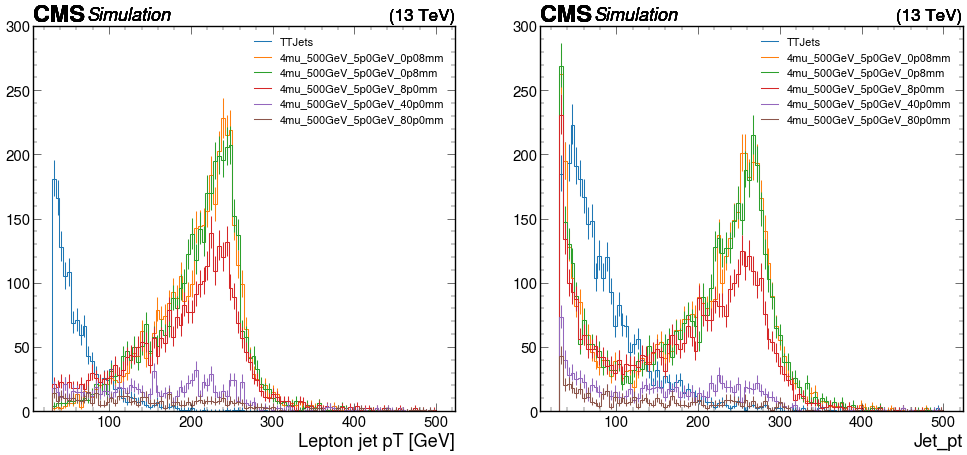

In [7]:
plt.subplots(1,2,figsize=(24,10))

plt.subplot(1,2,1)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["lj_pt"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.ylim(0,300)

plt.subplot(1,2,2)
for sample in samples_nano:
    utilities.plot(out[sample]["hists"]["jet_pt"][channels[0], :], flow='none', density=False)
plt.legend(samples_nano, loc=1, prop={'size': 16})
plt.ylim(0,300)